In [1]:
pip install umap-learn datashader holoviews

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Data Structures
import numpy  as np
import pandas as pd

# Corpus Processing
import re
import nltk.corpus
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

# K-Means
from sklearn import cluster
from sklearn.cluster import DBSCAN

# Visualization and Analysis
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# UMap
import umap
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import matplotlib.pyplot as plt
import colorcet
import matplotlib.colors
import matplotlib.cm

import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd
import umap.plot

# PCA
from sklearn.decomposition import PCA

# Random
import random

In [3]:
# download NLTK packages

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alekseyvalouev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alekseyvalouev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alekseyvalouev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/alekseyvalouev/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
data = pd.read_csv('usc_seating_data.csv', encoding='utf-8')
data_pre = data

In [5]:
data['Abstract 1'] = data['Abstract 1'].fillna(' ')
data['Abstract 2'] = data['Abstract 2'].fillna(' ')
data['Abstract 3'] = data['Abstract 3'].fillna(' ')
data['Provided Keywords'] = data['Provided Keywords'].fillna(' ')

In [6]:
data['added_abstracts'] = data['Abstract 1'] + ' ' + data['Abstract 2'] + ' ' + data['Abstract 3'] + 3*(' ' + data['Provided Keywords'])

In [7]:
random_assigned = data[(data['Random'] == 'yes') | (data['Skip'] == 'yes')]
random_assigned = random_assigned[['First name', 'Last Name', 'School', 'Category', 'PhD', 'Provided Keywords', 'Random', 'Skip', 'added_abstracts']]

In [8]:
data = data[data['Random'] != 'yes']
data = data[data['Skip'] != 'yes']

In [9]:
data_cleaned = data[['First name', 'Last Name', 'School', 'Category', 'PhD', 'Provided Keywords', 'Random', 'Skip', 'added_abstracts']]

In [10]:
data_cleaned

,First name,Last Name,School,Category,PhD,Provided Keywords,Random,Skip,added_abstracts
0,Kevin,Murphy,USC,Finance,No,,NaN,NaN,Finance theory says that companies in declinin...
1,Robert,Dittmar,University of Michigan,Finance,No,Asset pricing,NaN,NaN,We conduct a systematic examination of the ret...
2,Mitch,Warachka,Chapman University,Finance,No,Innovation\nValue Creation\nCulture,NaN,NaN,A large literature reports that proximity infl...
3,William,Mullins,UC San Diego,Finance,No,"Finance, Corporate and Household finance, poli...",NaN,NaN,We find evidence of selective exposure to conf...
4,Stan,Markov,UT Dallas,Accounting,No,"social media, big data, market efficiency,\",NaN,NaN,We examine how increased competition stemming ...
...,...,...,...,...,...,...,...,...,...
73,Kristi,Rennekamp,Cornell University,Accounting,No,,NaN,NaN,As firms increasingly use social media to prov...
74,Suzanne,Burzillo,USC,Accounting,Yes,,NaN,NaN,Recent years have witnessed growing interest i...
75,Nick,Bloom,Stanford,Economics,No,,NaN,NaN,We construct the World Uncertainty Index (WUI)...
76,Anastassia,Fedyk,Berkeley Haas,Finance,No,,NaN,NaN,We study the use and economic impact of artifi...


In [11]:
corpus = data_cleaned['added_abstracts'].tolist()

In [12]:
# removes stopwords from a tokenized list
def remove_stopwords(tokens, words):
    return [token for token in tokens if token not in words]

# apply stemming to a list of tokens
def apply_stemming(tokens, stemmer):
    return [stemmer.stem(token) for token in tokens]

# apply lemmatization to a list of tokens
def apply_lem(tokens, lemmatizer): 
    return [lemmatizer.lemmatize(token) for token in tokens]

# find words <= 2 letters or >= 21 letters
def find_two_letters(tokens):
    two_letters = []
    for token in tokens:
        if len(token) <= 2 or len(token) >= 21:
            two_letters.append(token)
    return two_letters

In [13]:
def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    param_lem = WordNetLemmatizer()
    other_words = [line.rstrip('\n') for line in open('stopwords_scrapmaker.txt')] # Load .txt file line by line
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = find_two_letters(listOfTokens)

        listOfTokens = remove_stopwords(listOfTokens, stopwords)
        listOfTokens = remove_stopwords(listOfTokens, other_words)
        listOfTokens = remove_stopwords(listOfTokens, twoLetterWord)
        
        listOfTokens = apply_lem(listOfTokens, param_lem)
        listOfTokens = remove_stopwords(listOfTokens, other_words)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [14]:
language = 'english'
corpus = processCorpus(corpus, language)

In [15]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

/Users/alekseyvalouev/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
def run_kmeans(k, data):
    kmeans = cluster.KMeans(n_clusters = k, init = 'k-means++', n_init = 10, tol = 0.0001, random_state = 1, algorithm = 'full')
    return kmeans.fit(data)

In [17]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats, columns):
    plt.rcParams.update({'font.size': 2})
    
    # Compute Rows required

    rows = len(dfs) // columns 
    rows += len(dfs) % columns

    # Create a Position index

    Position = range(1, len(dfs) + 1)
    
    fig = plt.figure(1, dpi=800)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.7)
    
    for i in range(0, len(dfs)):
        ax = fig.add_subplot(rows,columns,Position[i])
        
        ax.set_title(("Most Common Words in Cluster {}".format(i)), fontsize=3, fontweight='bold')
        
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
    
    plt.savefig('word_freq.png')
    plt.show()

In [18]:
k = 10
kmeans = run_kmeans(k, final_df)

In [19]:
labels = kmeans.labels_ 
data_cleaned['label'] = labels

/var/folders/tn/1hx74qln26x7jlmq6t6mlyqm0000gn/T/ipykernel_45453/3497286081.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['label'] = labels


In [20]:
unique_labels = np.unique(data_cleaned['label'])

def recursively_reassign(data, max_size):
    label_sizes = []
    
    data = data.reset_index(drop=True)
    
    for label in unique_labels:
        label_sizes.append(data[data['label'] == label]['label'].size)
    
    full_clusters = np.where(np.array(label_sizes) >= max_size, True, False)
    
    distances = kmeans.transform(final_df)
    
    dist_arr = np.argsort(distances, axis=1)
    
    full_arr = []
    
    i = 0
    for full in full_clusters:
        if full:
            full_arr.append(data.index[data['label'] == i].tolist())
        i+=1
        
    unwanteds = []
        
    for i in full_arr:
        sub_dists = []
        for j in i: 
            sub_dists.append(distances[j][dist_arr[j][0]])
        
        sub_dists_sorted = np.argsort(sub_dists)
        
        wanted_indices = sub_dists_sorted[:max_size]        
        unwanted = [x for x in i if x not in np.array(i)[wanted_indices].tolist()]
        
        for u in unwanted:
            unwanteds.append(u)
        
    if len(unwanteds) > 3:
        for i in unwanteds:
            for j in dist_arr[i]:
                if not full_clusters[j]:
                    data.at[i, 'label'] = j
                    
        data = recursively_reassign(data, max_size)
        
        return data
        
    else:
        for i in unwanteds:
            data.at[i, 'label'] = dist_arr[i][1]
            
        return data
        
data_cleaned = recursively_reassign(data_cleaned, 6)

/Users/alekseyvalouev/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


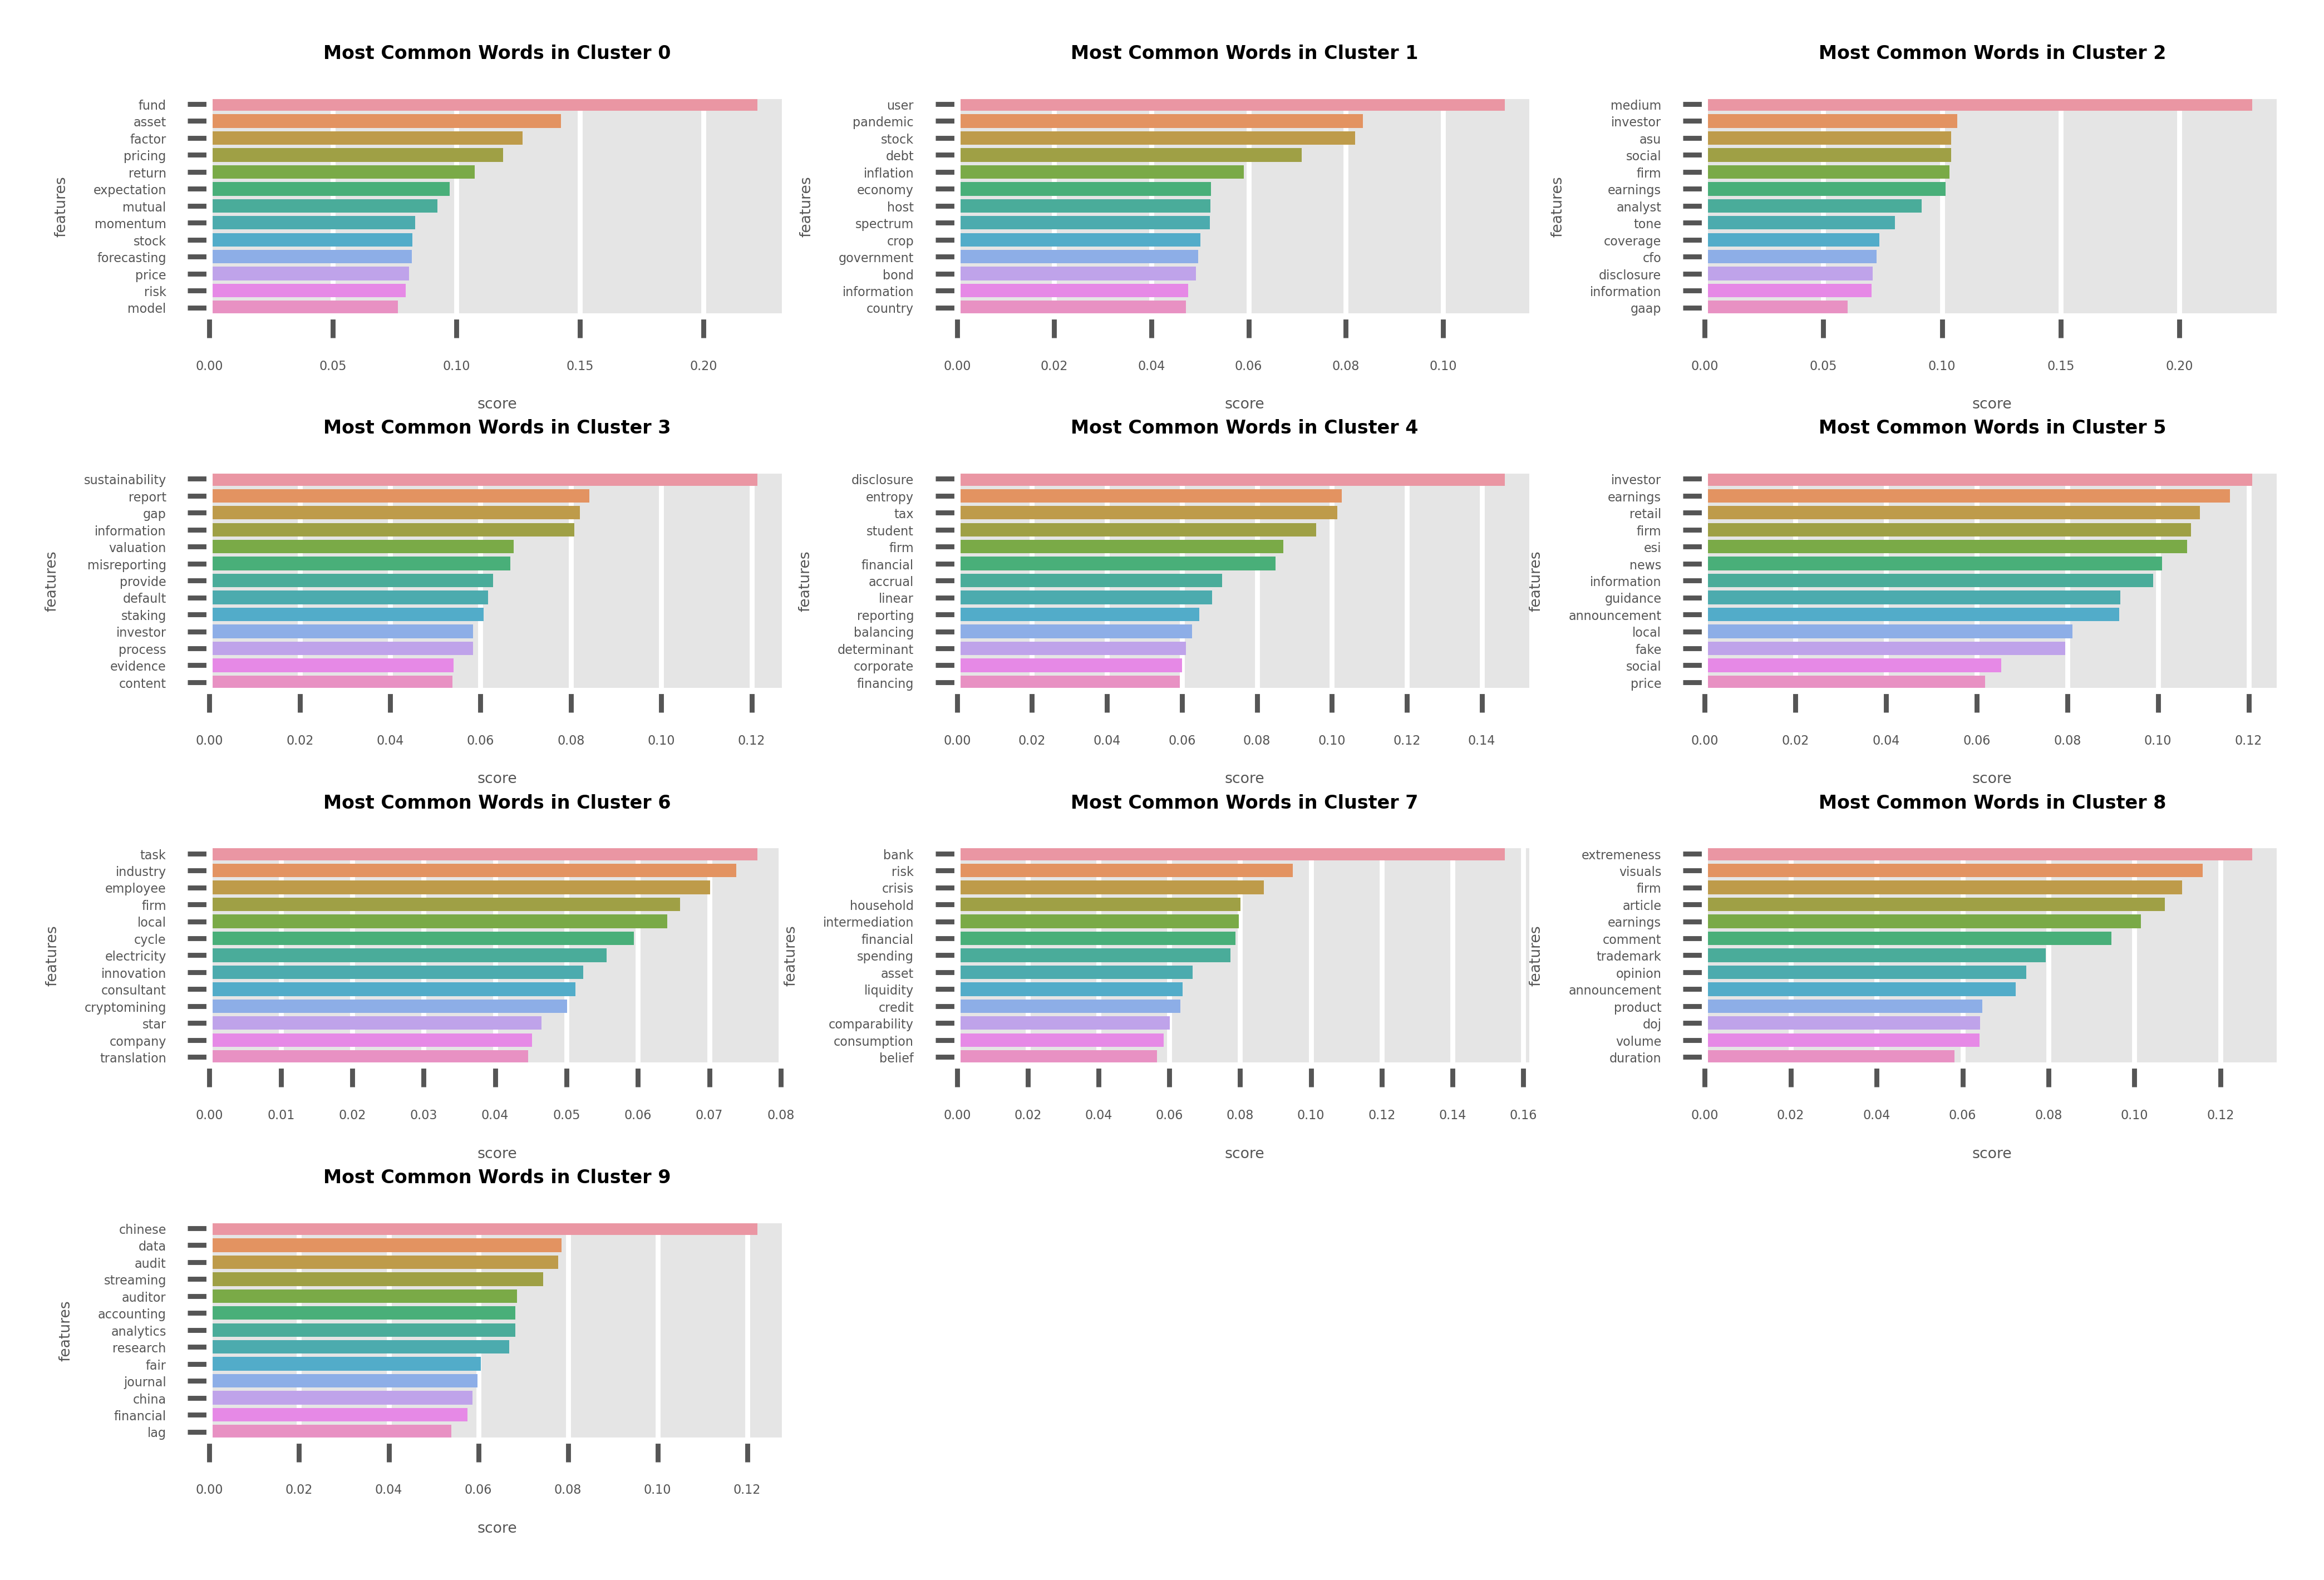

In [41]:
final_df_array = final_df.to_numpy()
prediction = data_cleaned['label']
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13, 3)

In [22]:
# We train the PCA on the dense version of the tf-idf. 
pca = PCA(n_components=2)
two_dim = pca.fit_transform(final_df)

scatter_x = two_dim[:, 0] # first principle component
scatter_y = two_dim[:, 1] # second principle component

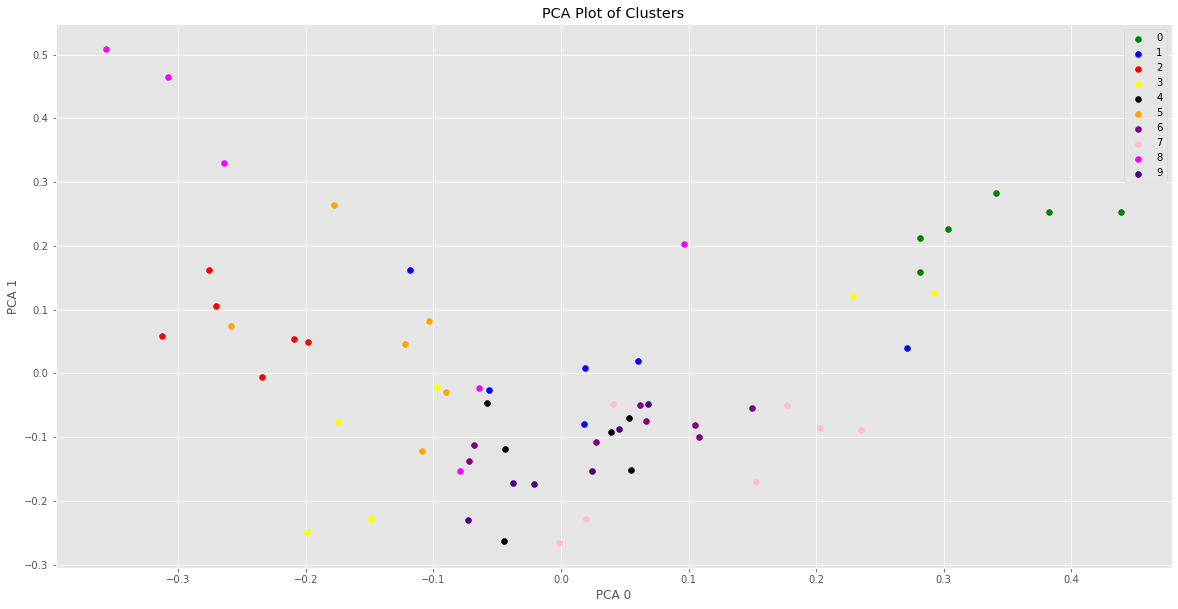

In [23]:
plt.style.use('ggplot')

fig, ax = plt.subplots()
fig.set_size_inches(20,10)

# color map for all clusters we have
cmap = {0: 'green', 1: 'blue', 2: 'red', 3: 'yellow', 4 : 'black', 5: 'orange', 6: 'purple', 7: 'pink', 8: 'magenta', 9: 'indigo'}

# group by clusters and scatter plot every cluster
# with a colour and a label
for group in np.unique(prediction):
    ix = np.where(prediction == group)
    ax.scatter(scatter_x[ix], scatter_y[ix], c=cmap[group], label=group)

ax.legend()
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")
plt.title("PCA Plot of Clusters")
plt.show()

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


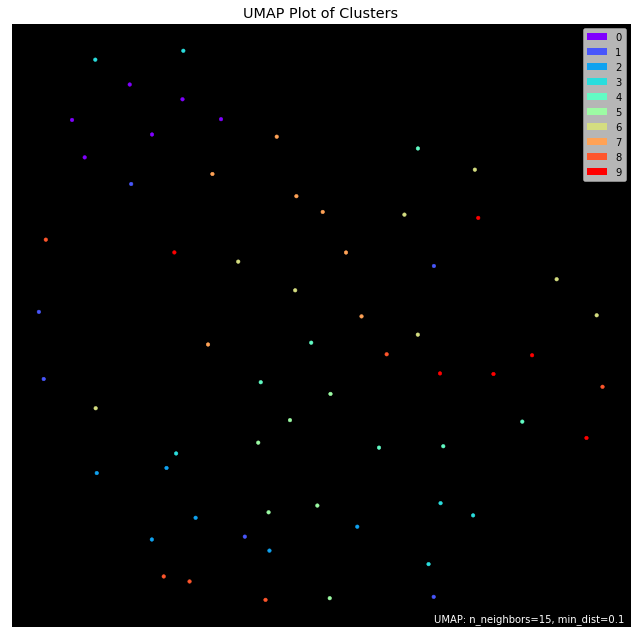

In [24]:
tfidf_embedding = umap.UMAP().fit(final_df)
fig = umap.plot.points(tfidf_embedding, labels=prediction, theme='fire')
plt.title("UMAP Plot of Clusters")
plt.show()

In [25]:
def display_freq(data, columns, label):
    plt.rcParams.update({'font.size': 2})
    
    # Compute Rows required

    rows = len(data) // columns 
    rows += len(data) % columns

    # Create a Position index

    Position = range(1, len(dfs) + 1)
    
    fig = plt.figure(1, dpi=800)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.7)
    fig.tight_layout()
    
    for i in range(0, len(data)):
        ax = fig.add_subplot(rows,columns,Position[i])
        
        ax.set_title((label + " in Cluster {}".format(i)), fontsize=3, fontweight='bold')
        
        counter = data[i].value_counts()
        
        trunc_index = [i[:16] for i in counter.index]
        
        plt.bar(trunc_index,counter.values)  
    
        plt.setp(ax.get_xticklabels(), rotation=10)#, horizontalalignment='right')
        
    plt.savefig('%s.png' % label)
    
    plt.show()

In [26]:
data_final = data_cleaned

In [27]:
data_final = pd.concat([data_final, random_assigned[random_assigned["Last Name"] == "Dechow"]])

In [28]:
random_assigned = random_assigned.loc[random_assigned["Last Name"] != "Dechow"]

In [29]:
data_final.loc[data_final["Last Name"] == "Dechow", "label"] = int(data_final[data_final["Last Name"] == "Heese"]["label"])

In [30]:
unique_labels = np.unique(data_cleaned['label'])

label_sizes = []

for label in unique_labels:
    label_sizes.append(data_final[data_final['label'] == label]['label'].size)

In [31]:
label_sizes = np.array([8]*len(label_sizes))-np.array(label_sizes)

In [32]:
i = 0 

random_labels = []

for label in label_sizes:
    for j in range(label):
        random_labels.append(i)
    i+=1

In [33]:
random.shuffle(random_labels)

random_labels = random_labels[:len(random_assigned)]

In [34]:
random_assigned["label"] = random_labels

In [35]:
data_final = pd.concat([data_final, random_assigned])

In [36]:
data_final = data_final.reset_index(drop=True)

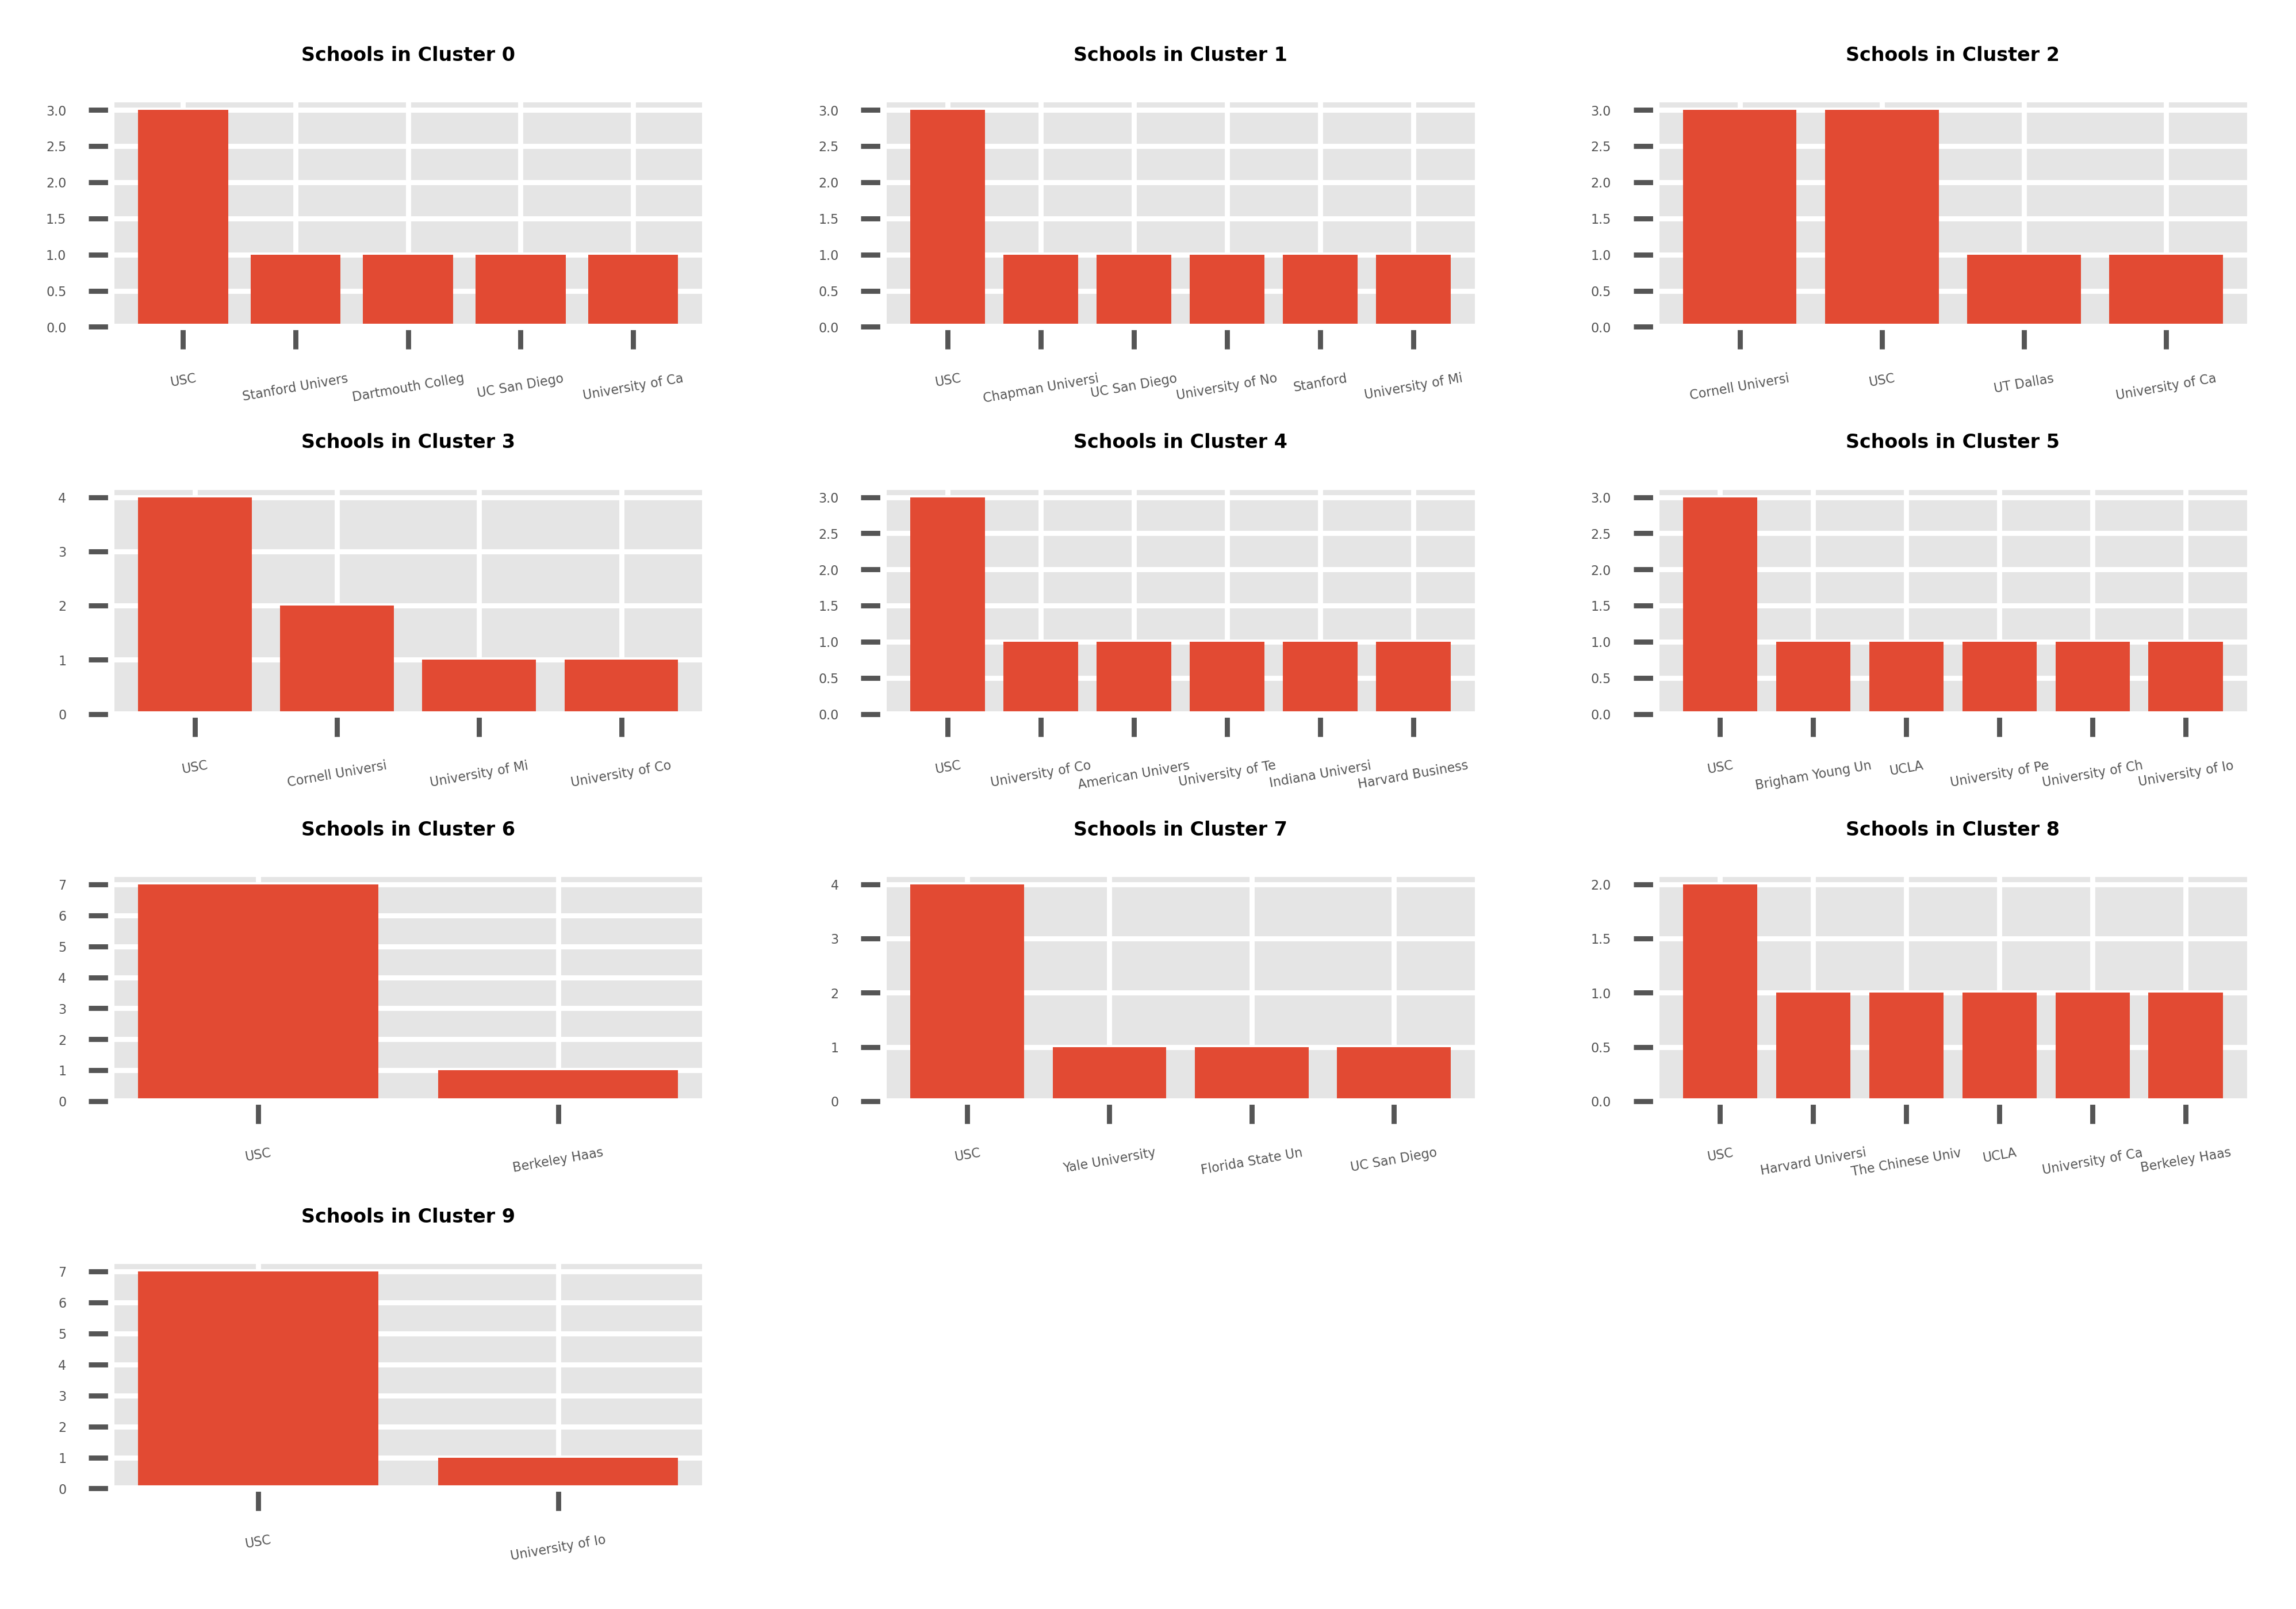

In [37]:
clusters = np.unique(data_final['label'])

cluster_list = []

for cluster in clusters:
    schools = data_final[data_final['label'] == cluster]['School']
    
    cluster_list.append(schools)
    
display_freq(cluster_list, 3, "Schools")

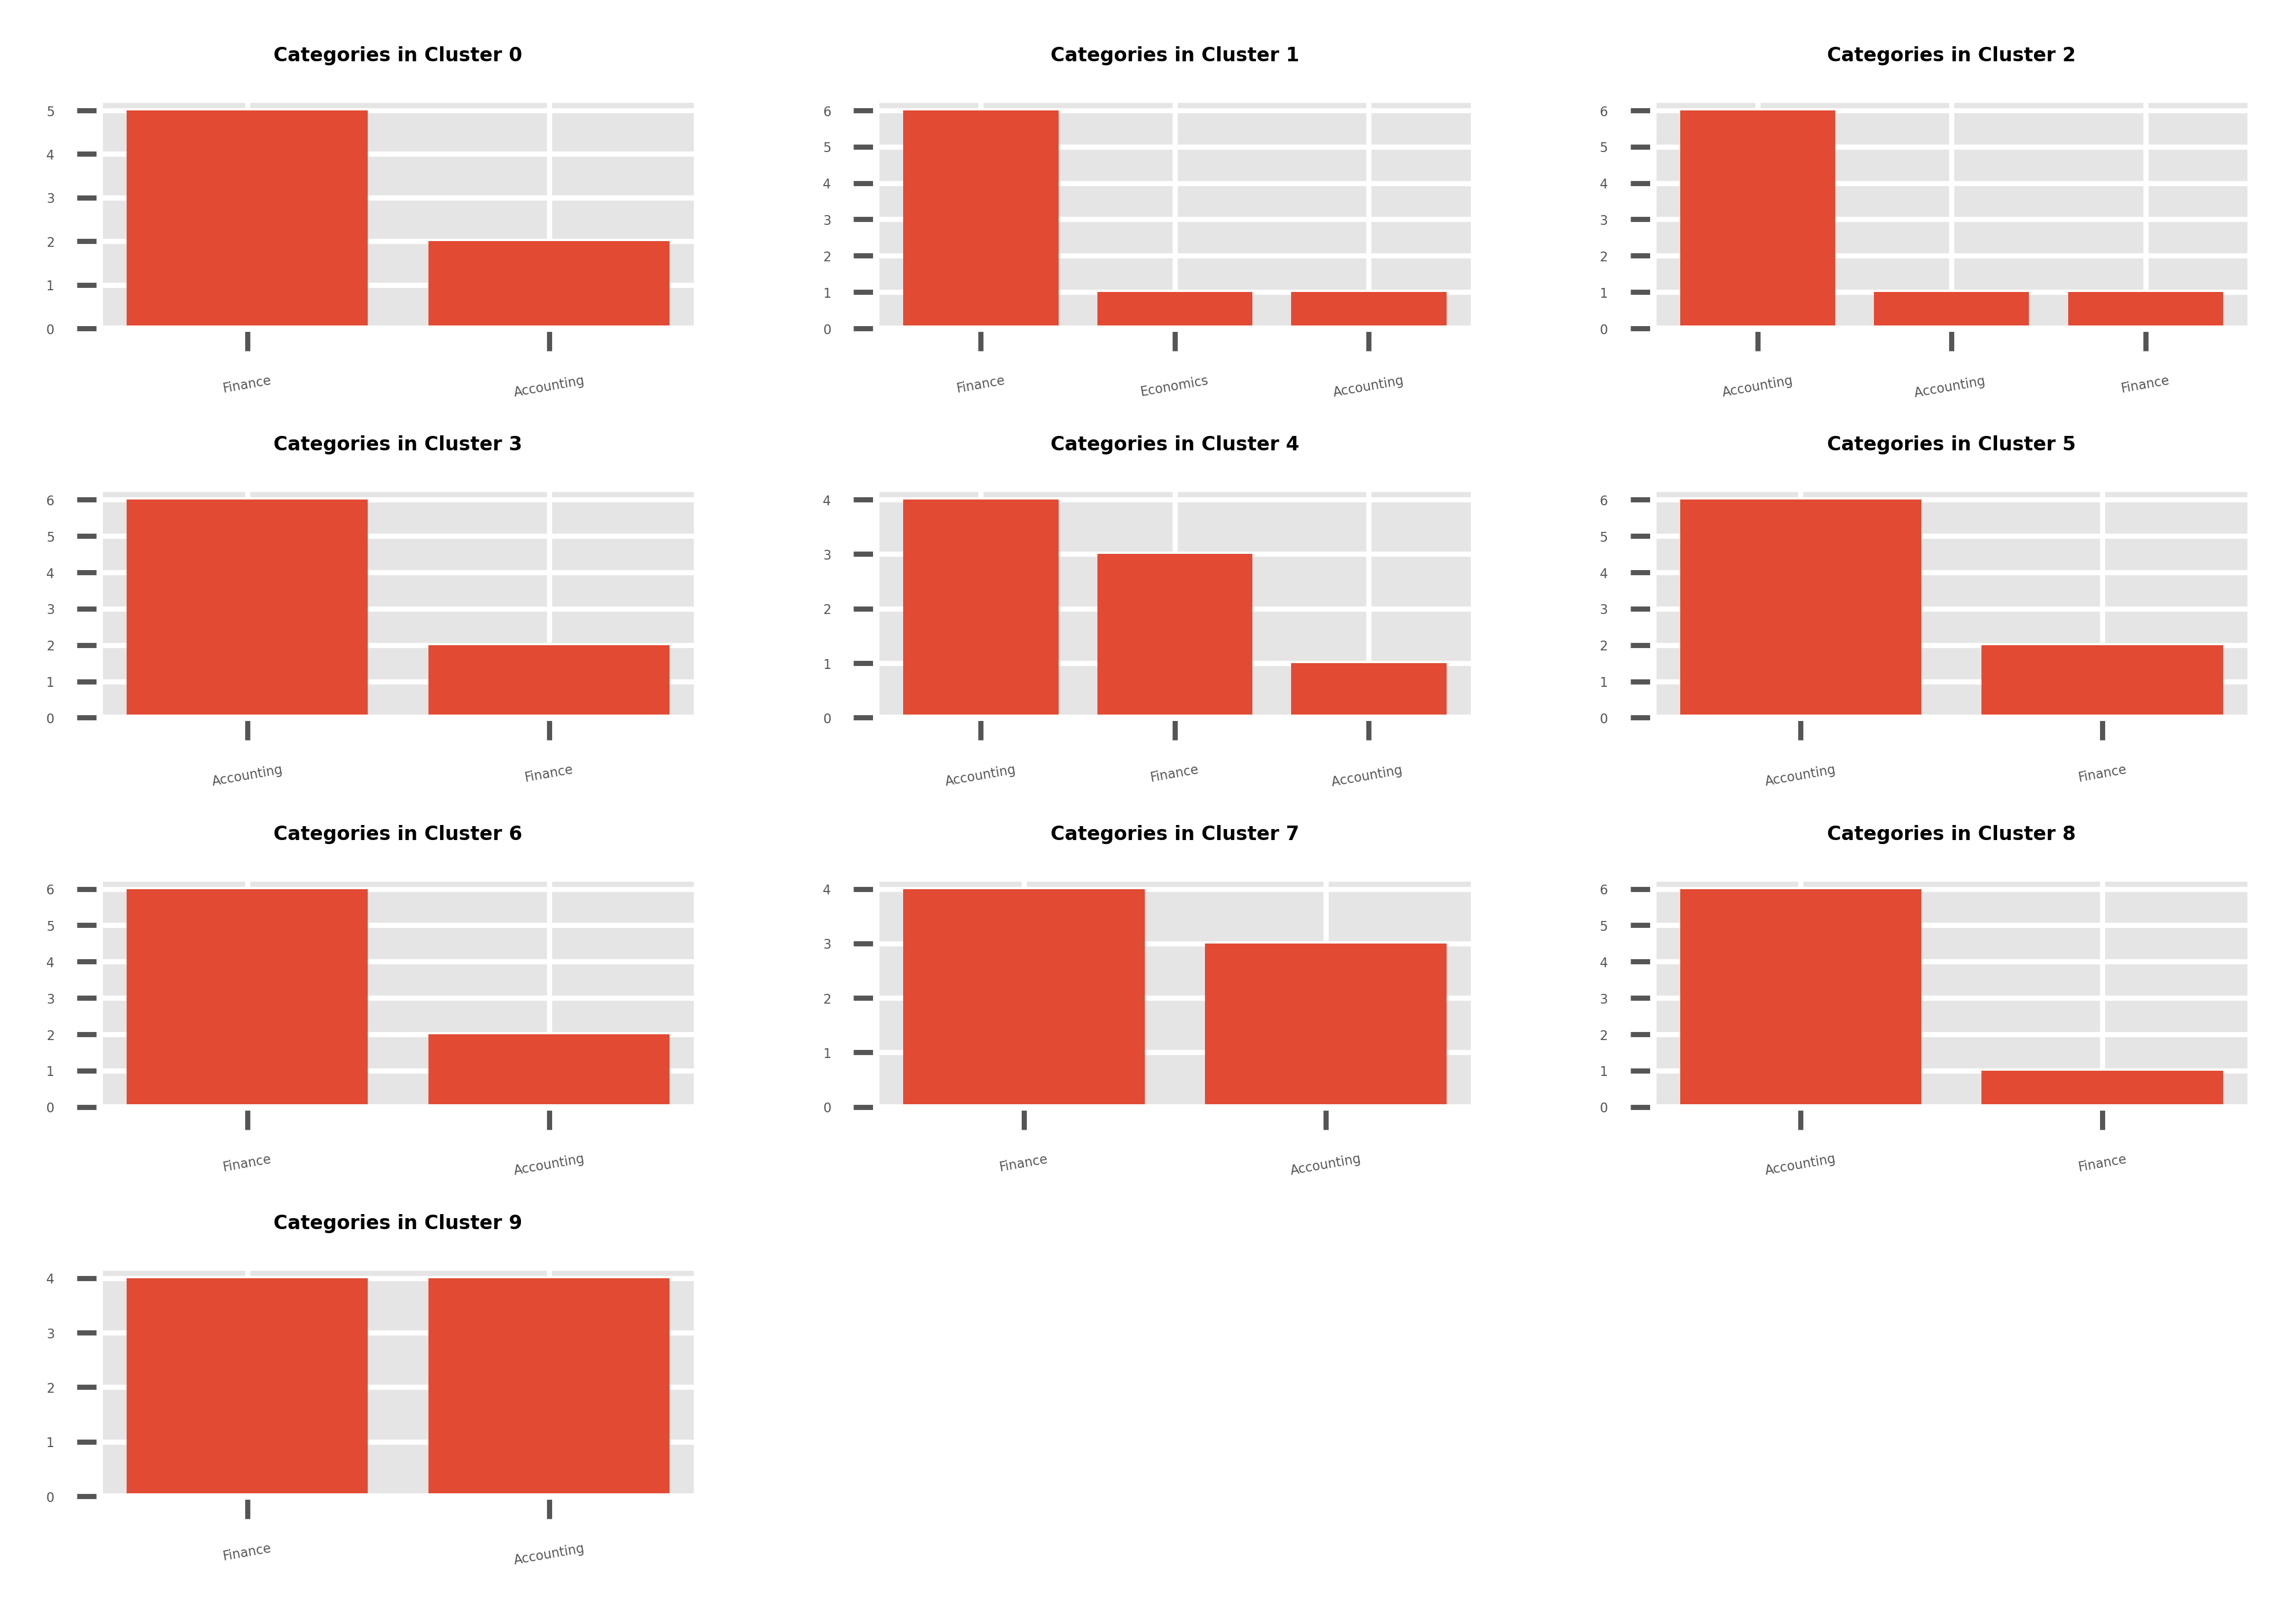

In [38]:
clusters = np.unique(data_final['label'])

cluster_list = []

for cluster in clusters:
    schools = data_final[data_final['label'] == cluster]['Category']
    
    cluster_list.append(schools)
    
display_freq(cluster_list, 3, "Categories")

In [39]:
clusters = np.unique(data_final['label'])

df_rows = []

for cluster in clusters:
    names = data_final[data_final['label'] == cluster]["First name"] + ' ' + data_final[data_final['label'] == cluster]["Last Name"]
    outstr = ""
    for name in names.tolist():
        outstr+=(name+', ')
    outstr = outstr[:-2]
    df_rows.append(["Table %s" % str(int(cluster) + 1), outstr])
    
seating = pd.DataFrame(df_rows, columns = ['Table', 'People'])

In [40]:
seating.to_csv("final_seats.csv", index=False)